### Import dan persiapan

In [1]:
import torch
from torchvision import transforms, datasets
import os
import matplotlib.pyplot as plt

In [2]:
os.listdir('apple_leaf_dataset/backbone/valid_backbone')
# target_names = {lbl:num for num, lbl in enumerate(os.listdir('apple_leaf_dataset/backbone/train_backbone'))}

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

In [21]:
target_names['Apple___Apple_scab']

0

In [ ]:
target_names = {lbl:num for num, lbl in enumerate(os.listdir('apple_leaf_dataset/backbone/train_backbone'))}

In [32]:
target_names

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3}

In [39]:
fn_label = lambda label: torch.tensor(target_names[label])
fn_label('Apple___Apple_scab')

tensor(0)

In [3]:
train_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])

valid_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])


### Dataset *Backbone*

In [ ]:
train_dataset = datasets.ImageFolder(root='apple_leaf_dataset/backbone/train_backbone',
                                           transform=train_transform,)
                                        #    target_transform=transforms.Lambda(lambda label: torch.tensor(target_names[label])) )
valid_dataset = datasets.ImageFolder(root='apple_leaf_dataset/backbone/valid_backbone',
                                           transform=valid_transform,)
                                        #    target_transform=transforms.Lambda(lambda label: torch.tensor(target_names[label])) )


In [71]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 6771
    Root location: apple_leaf_dataset/backbone/train_backbone
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [72]:
valid_dataset

Dataset ImageFolder
    Number of datapoints: 1643
    Root location: apple_leaf_dataset/backbone/valid_backbone
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [73]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=16, shuffle=True,
                                             num_workers=4)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=16, shuffle=False,
                                             num_workers=1)

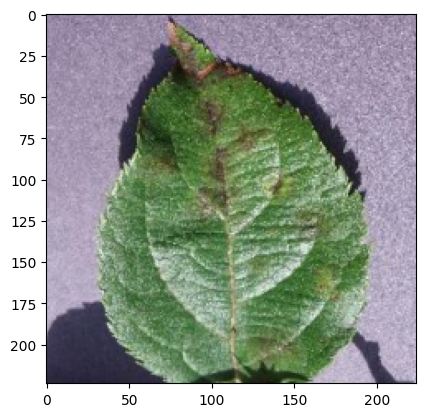

In [75]:
img, lbl = next(iter(train_loader))

image= img[-1] 
image = image.permute(1,2,0)
# image.shape
image = image * 0.5 + 0.5
image = image.cpu().numpy()

plt.imshow(image)

In [69]:
image.shape

(224, 224, 3)

### Dataset Mask R-CNN

In [13]:
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import numpy as np
import cv2
from PIL import Image

In [7]:
# Custom PyTorch Dataset to load COCO-format annotations and images
class CocoSegmentationDataset(Dataset):
    # Init function: loads annotation file and prepares list of image id's
    def __init__(self, root_dir, annotation_file, transforms=None):
        """
        root_dir: path to the folder containing images (e.g. car_parts_dataset/train/)
        annotation_file: path to the COCO annotations (e.g. car_parts_dataset/train/_annotations.coco.json)
        """
        self.root_dir = root_dir
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms
    
    # Returns total number of images
    def __len__(self):
        return len(self.image_ids)

    # Fetches a single image and its annotations
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.root_dir, image_info["file_name"])
        image = Image.open(image_path).convert("RGB")
        
        # Load all annotations for this image
        annotation_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(annotation_ids)
        
        # Extract segmentation masks,bounding boxes and labels from annotations
        boxes = []
        labels = []
        masks = []
        
        for ann in annotations:
            xmin, ymin, w, h = ann['bbox']
            xmax = xmin + w
            ymax = ymin + h
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(ann['category_id'])
            mask = self.coco.annToMask(ann)
            masks.append(mask)
        
        boxes = torch.as_tensor( np.array(boxes), dtype=torch.float32) #numpy.array()
        labels = torch.as_tensor( np.array(labels), dtype=torch.int64)
        masks = torch.as_tensor( np.array(masks), dtype=torch.uint8)


        area = torch.as_tensor([ann['area'] for ann in annotations], dtype=torch.float32)
        iscrowd = torch.as_tensor([ann.get('iscrowd', 0) for ann in annotations], dtype=torch.int64)
        
        # store everything in a dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # Apply transforms
        if self.transforms:
            image = self.transforms(image)
       
        # Return the processed image and its annotations
        return image, target

In [ ]:
train_dataset = CocoSegmentationDataset(
    root_dir=r'apple_leaf_dataset/rcnn/train_coco3/images',
    annotation_file=r'apple_leaf_dataset/rcnn/train_coco3/result.json',
    transforms=transforms.ToTensor()  # define this if needed
)

valid_dataset = CocoSegmentationDataset(
    root_dir=r'apple_leaf_dataset/rcnn/valid_coco/images',
    annotation_file=r'apple_leaf_dataset/rcnn/valid_coco/result.json',
    transforms=transforms.ToTensor()
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)),
                          num_workers=8)
val_loader = DataLoader(valid_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)),
                        num_workers=0)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [28]:
print("banyak train_dataset:", train_dataset.__len__())

banyak train_dataset: 60


In [29]:
print("banyak valid_dataset:", valid_dataset.__len__())

banyak valid_dataset: 14


In [10]:
CLASS_NAMES = [
    "scab", "Black_rot", "Cedar_rust", "Leaf"
]

In [19]:
def show_images_maskrcnn(data_loader):
    images, targets = next(iter(data_loader))

    for i in range(len(images)):
        # Convert image tensor to numpy array
        image = images[i].permute(1, 2, 0).cpu().numpy()
        image = (image * 255).astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        overlay = image.copy()
        
        # Extract masks, bounding boxes, and labels for the current image
        masks = targets[i]['masks'].cpu().numpy()
        boxes = targets[i]['boxes'].cpu().numpy()
        labels = targets[i]['labels'].cpu().numpy()

        for j in range(len(masks)):
            mask = masks[j]
            box = boxes[j]
            label_id = labels[j]

            # Get class name from mapping
            class_name = CLASS_NAMES[label_id]  # assuming 0-based labels

            # Random color
            color = np.random.randint(0, 255, (3,), dtype=np.uint8).tolist()

            # Alpha blend mask
            colored_mask = np.zeros_like(image, dtype=np.uint8)
            for c in range(3):
                colored_mask[:, :, c] = mask * color[c]
            alpha = 0.4
            overlay = np.where(mask[..., None], 
                            ((1 - alpha) * overlay + alpha * colored_mask).astype(np.uint8), 
                            overlay)

            # Draw label
            x1, y1, x2, y2 = map(int, box)
            cv2.putText(overlay, class_name, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX,
                        0.4, color, 1, lineType=cv2.LINE_AA)
            # for b in box:
            #     x1, y1, x2, y2 = cv2.boundingRect(b) #map(int, box)
            #     cv2.putText(overlay, class_name, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX,
            #                 0.8, color, 2, lineType=cv2.LINE_AA)


        # Show the result
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Sample {i + 1}")
        plt.show()

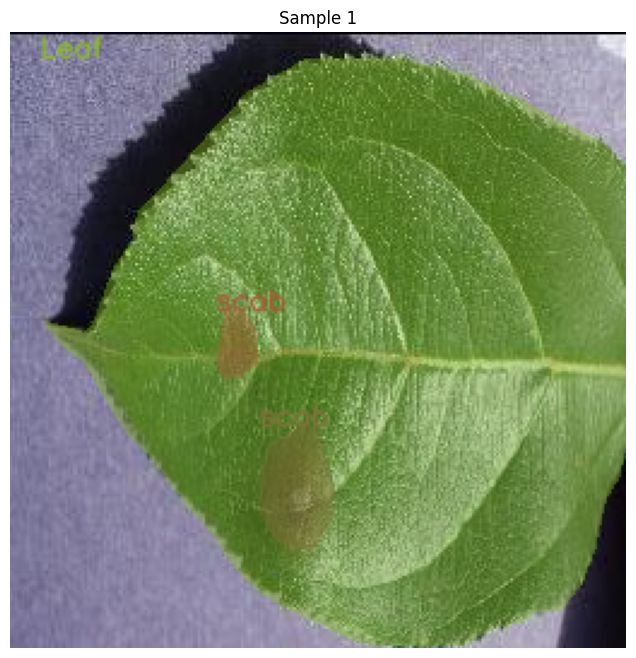

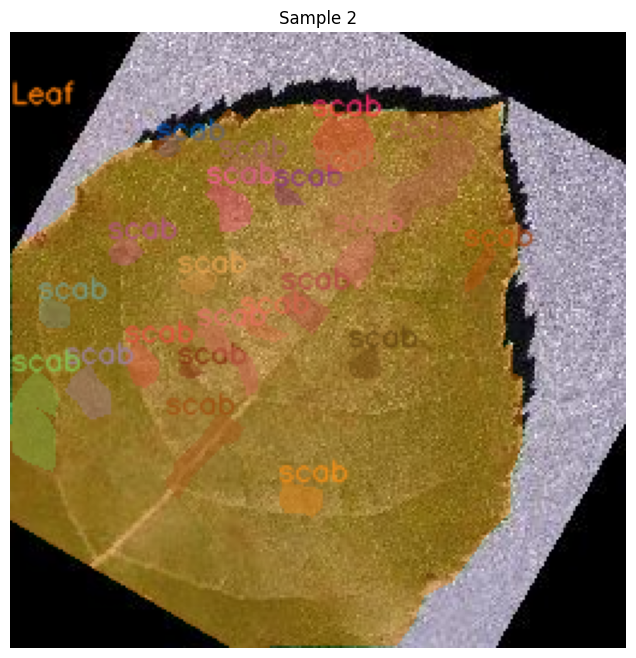

In [20]:
show_images_maskrcnn(train_loader)

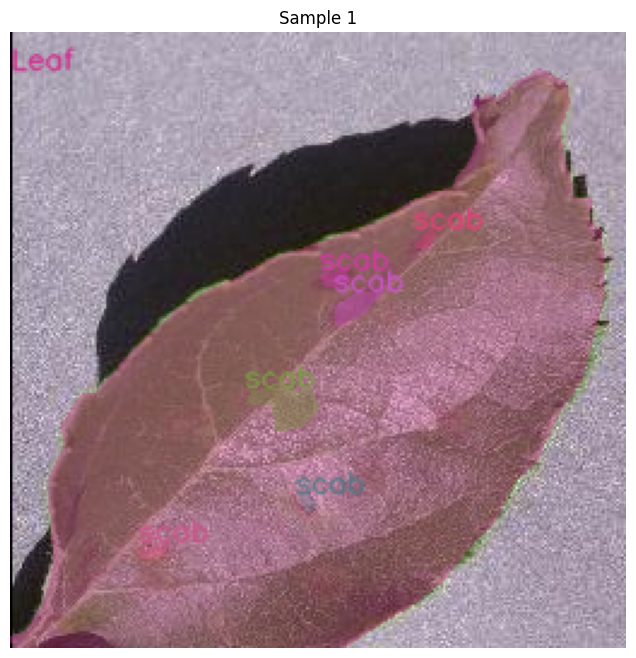

In [21]:
show_images_maskrcnn(val_loader)